In [12]:
import warnings
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, roc_curve
import optuna.integration.lightgbm as lgbo
from lightgbm import early_stopping
from lightgbm import log_evaluation
from imblearn.under_sampling import RandomUnderSampler

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [78]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240614_train.csv')
test = pd.read_csv('../data/row/test.csv')
train_01 = train['target'].apply(lambda x: 1 if x <-30 else 0).rename('target_binary')


In [79]:
train_01

0         0
1         0
2         0
3         0
4         0
         ..
201912    0
201913    0
201914    0
201915    0
201916    0
Name: target_binary, Length: 201917, dtype: int64

In [80]:
train_binary = pd.concat([train,train_01], axis=1).drop('target', axis=1)
train_binary


,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std,target_binary
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.

In [20]:
rus = RandomUnderSampler(random_state=0)
train_rus = rus.fit_resample(train_binary, train_binary['target_binary'])

print('0の件数', len(train_rus[0].query('target_binary == 0')))
print('1の件数', len(train_rus[0].query('target_binary == 1')))

0の件数 2207
1の件数 2207


In [24]:
train = train_rus[0]

In [25]:
# 目的変数と説明変数の作成
target = train['target_binary']
del train['target_binary']

In [28]:
best_params = {'objective': 'binary',
               'metric': 'auc',
               'learning_rate': 0.1,
               'random_seed': 0,
               'feature_pre_filter': False,
               'lambda_l1': 1.3333379399135385e-07,
               'lambda_l2': 5.941811936480079,
               'num_leaves': 11,
               'feature_fraction': 0.5,
               'bagging_fraction': 1.0,
               'bagging_freq': 0,
               'min_child_samples': 100}

In [29]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [30]:
#lightgbm
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
        label=target.iloc[trn_idx],
        categorical_feature=categorical_feats
    )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
        label=target.iloc[val_idx],
        categorical_feature=categorical_feats
    )
    num_round = 10000
    clf = lgb.train(params=best_params,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                            lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/nichimodel_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)


fold n°0
[LightGBM] [Info] Number of positive: 1763, number of negative: 1768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25619
[LightGBM] [Info] Number of data points in the train set: 3531, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499292 -> initscore=-0.002832
[LightGBM] [Info] Start training from score -0.002832
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.890984
[200]	valid_0's auc: 0.888455
[300]	valid_0's auc: 0.885484
Early stopping, best iteration is:
[124]	valid_0's auc: 0.892164
fold n°1
[LightGBM] [Info] Number of positive: 1791, number of negative: 1740
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25769
[Light

In [31]:
oof

array([0.25507292, 0.70266493, 0.13746368, ..., 0.85168241, 0.81404508,
       0.96347804])

In [68]:
roc

(array([0.00000000e+00, 0.00000000e+00, 4.53103761e-04, ...,
        9.56502039e-01, 9.56502039e-01, 1.00000000e+00]),
 array([0.00000000e+00, 4.53103761e-04, 4.53103761e-04, ...,
        9.99546896e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.98345476, 0.98218499, ..., 0.02376472, 0.02365507,
        0.00402988]))

In [69]:
distance = fpr**2 + (1-tpr)**2
min_index = distance.argmin()
threshold = thresholds[min_index]

In [70]:
threshold

0.5098905599879988

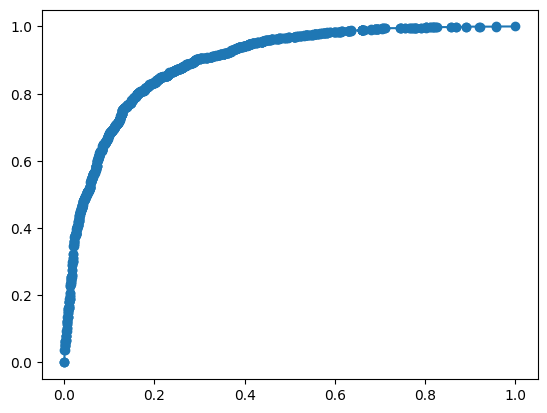

In [71]:
# oof_binary = np.where(oof >= 0.6, 1, 0)
roc = roc_curve(target, oof)
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')



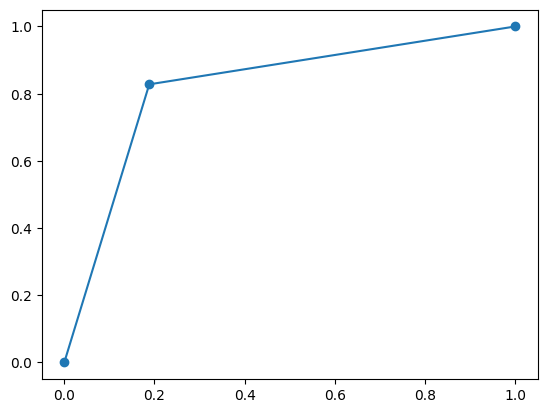

In [72]:
oof_binary = np.where(oof >= threshold, 1, 0)
roc = roc_curve(target, oof_binary)
fpr, tpr, thresholds = roc
plt.plot(fpr, tpr, marker='o')


(array([932., 399., 330., 261., 214., 223., 229., 352., 719., 755.]),
 array([0.00402988, 0.10197237, 0.19991486, 0.29785735, 0.39579983,
        0.49374232, 0.59168481, 0.6896273 , 0.78756978, 0.88551227,
        0.98345476]),
 <BarContainer object of 10 artists>)

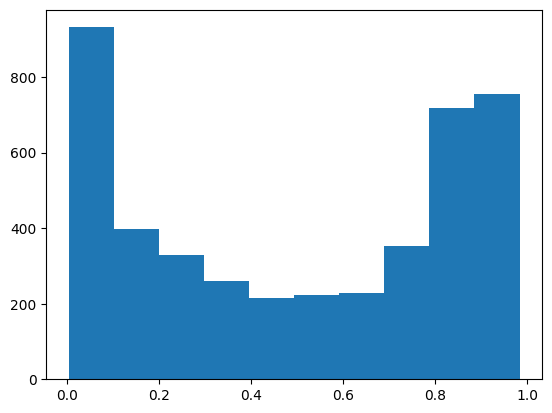

In [33]:
plt.hist(oof)

In [76]:
train_rus[0]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
43921,2017-08-01,C_ID_85817f32a5,2,1,0,184,2.0,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,0.500000,2.0,2.0,1.0,2.0,2.0,-1.292866,-0.646433,-0.591038,-0.701828,0.078341,3.0,1.500